<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/Monodepth2_kitti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/Niantic/monodepth2.git

Cloning into 'monodepth2'...
remote: Enumerating objects: 169, done.
remote: Total 169 (delta 0), reused 0 (delta 0), pack-reused 169
Receiving objects: 100% (169/169), 10.27 MiB | 11.30 MiB/s, done.
Resolving deltas: 100% (81/81), done.


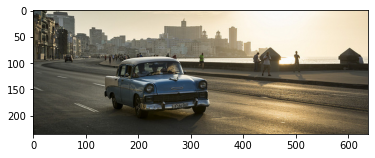

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(Image.open("/content/monodepth2/assets/test_image.jpg"))

/content/monodepth2
-> Downloading pretrained model to models/mono+stereo_640x192.zip
   Unzipping model...
   Model unzipped to models/mono+stereo_640x192
-> Loading model from  models/mono+stereo_640x192
   Loading pretrained encoder
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved predictions to:
   - assets/test_image_disp.jpeg
   - assets/test_image_disp.npy
-> Done!
/content


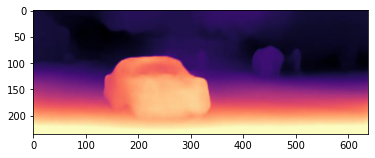

(<matplotlib.image.AxesImage at 0x7f2fd8132760>, None)

In [6]:
%cd monodepth2
!python test_simple.py --image_path assets/test_image.jpg --model_name mono+stereo_640x192
%cd ..
plt.imshow(Image.open("/content/monodepth2/assets/test_image_disp.jpeg")), plt.show()

In [7]:
!pip -q install open3d
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


# rgbd
disp = np.array(Image.open("/content/monodepth2/assets/test_image_disp.jpeg"))
img = np.array(Image.open("/content/monodepth2/assets/test_image.jpg"))
depth_o3d = o3d.geometry.Image(disp)
image_o3d = o3d.geometry.Image(img)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    image_o3d, depth_o3d, convert_rgb_to_intensity=False)

# intrinsic
h = int(disp.shape[0])
w = int(disp.shape[1])
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(w, h, 500, 500, w/2, h/2)#500, 500, 640,512
# camera_intrinsic.set_intrinsics(w, h, 1035, 1035, 597, 520)#1035, 1035, 597,520
print('intrinsic:\n', camera_intrinsic.intrinsic_matrix)

# invalidate existing normals
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
pcd.normals = o3d.utility.Vector3dVector(np.zeros((1, 3)))  
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))
pcd.orient_normals_towards_camera_location(camera_location=np.array([0., 0., 1000.]))
pcd.transform([[1, 0, 0, 0],
                [0, -1, 0, 0],
                [0, 0, -1, 0],
                [0, 0, 0, 1]])
pcd.transform([[-1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]]) 

# run Poisson surface reconstruction
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh_raw, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=10, width=0, scale=1.1, linear_fit=True)

voxel_size = max(mesh_raw.get_max_bound() - mesh_raw.get_min_bound()) / 256
print(f'voxel_size = {voxel_size:e}')
mesh = mesh_raw.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)

# vertices_to_remove = densities < np.quantile(densities, 0.001)
# mesh.remove_vertices_by_mask(vertices_to_remove)
bbox = pcd.get_axis_aligned_bounding_box() 
mesh_crop = mesh.crop(bbox)
mesh_crop = o3d.geometry.TriangleMesh.compute_triangle_normals (mesh_crop)
img_path = "pcd" # 'monodepth2/assets/pcd'
gltf_path = f'./{img_path}.gltf'
stl_path = f'./{img_path}.stl'
o3d.io.write_triangle_mesh("pcd.gltf", mesh_crop, write_triangle_uvs=True)
o3d.io.write_triangle_mesh("pcd.stl", mesh_crop, write_triangle_uvs=True) #ply/stl/obj/off/gltf
mesh = o3d.io.read_triangle_mesh('/content/pcd.stl')
print(mesh)
# o3d.visualization.draw_geometries([mesh_crop])

from google.colab import files

files.download('/content/pcd.stl')
files.download('/content/pcd.gltf')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.7 MB/s eta 0:00:00
intrinsic:
 [[500.    0.  319. ]
 [  0.  500.  117.5]
 [  0.    0.    1. ]]
[Open3D DEBUG] Input Points / Samples: 149888 / 72898
[Open3D DEBUG] #   Got kernel density: 0.0787311 (s), 323.645 (MB) / 323.645 (MB) / 323 (MB)
[Open3D DEBUG] #     Got normal field: 0.317542 (s), 360.684 (MB) / 360.684 (MB) / 360 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 4.019944e-06 / 6.025413e-01
[Open3D DEBUG] #       Finalized tree: 0.447531 (s), 412.762 (MB) / 412.762 (MB) / 412 (MB)
[Open3D DEBUG] #  Set FEM constraints: 3.35086 (s), 395.738 (MB) / 412.762 (MB) / 412 (MB)
[Open3D DEBUG] #Set point cons

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip -q install numpy-stl

In [28]:
!mkdir images

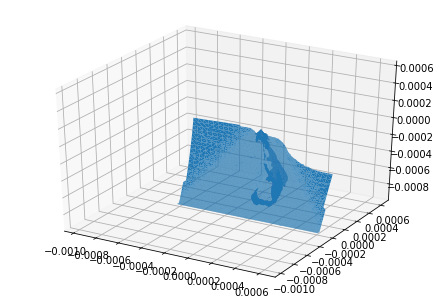

In [32]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt

# Create a new plot
figure = plt.figure()
axes = mplot3d.Axes3D(figure)

# Load the STL files and add the vectors to the plot
mesh = mesh.Mesh.from_file('pcd.stl') # Mesh with 77255 items
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh.vectors))

# Auto scale to the mesh size
points = mesh.points #ndarray with shape (77255, 9)
scale = mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)
plt.show()

# train from scratch

In [9]:
!pip install Pillow==6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 32.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Pillow: filename=Pillow-6.1.0-cp38-cp38-linux_x86_64.whl size=1219522 sha256=f91d99dc853e3db67e952b0478378c77227e99b62e517aea28598fc85c4ea50c
  Stored in directory: /root/.cache/pip/wheels/ba/06/98/fd19a6f316adbd42868e207968254fd4b528d58de8841140a2
Successfully built Pillow
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 6.1.0 which is incompatible.


In [11]:
!pip install tensorboardX==1.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 KB 7.9 MB/s eta 0:00:00


In [36]:
# !pip install pytorch #==0.4.1 
# !pip install torchvision==0.2.1 

# !pip install opencv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
  error: subprocess-exited-with-error
  
  × Running setup.py install for pytorch did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for pytorch ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> pytorch

note: This is an issue with the package mentioned above, not pip.
hint: See above for output from the failure.
Looking in indexes: ht

In [4]:
!git clone https://github.com/nianticlabs/monodepth2.git
# !git clone https://github.com/ItsShi/monodepth2.git


Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180
Receiving objects: 100% (180/180), 10.27 MiB | 15.74 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [5]:
%cd monodepth2
!wget -i splits/kitti_archives_to_download.txt -P kitti_data/
%cd ..

/monodepth2
--2023-02-21 18:42:44--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.91
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘kitti_data/2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2023-02-21 18:42:45 (217 MB/s) - ‘kitti_data/2011_09_26_calib.zip’ saved [4068/4068]

--2023-02-21 18:42:45--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip
Reusing existing connection to s3.eu-central-1.amazonaws.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 458643963 (437M) [application/zip]
Saving to: ‘kitti_data/2011_09_26_drive_0001_sync.zip’

2011_09_26_drive_00 100%[===================

In [7]:
%cd content
%cd /monodepth2
%cd kitti_data
!unzip -q "*.zip"
%cd ..

/content
/monodepth2
/monodepth2/kitti_data
[2011_09_26_drive_0009_sync.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.

4 archives were successfully processed.
1 file had no zipfile directory.
/monodepth2


In [8]:
!find kitti_data/ -name '*.png' | parallel 'convert -quality 92 -sampling-factor 2x2,1x1,1x1 {.}.png {.}.jpg && rm {}'

In [12]:
!python train.py --model_name mono_640x192

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100% 44.7M/44.7M [00:00<00:00, 88.1MB/s]
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 